In [0]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np
from keras.preprocessing.image import array_to_img, img_to_array

In [0]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [0]:
from keras.datasets import mnist

In [0]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

In [0]:
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

W0711 03:09:05.348268 139704323200896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 03:09:05.391201 139704323200896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 03:09:05.398552 139704323200896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(
        shape = (K.shape(z_mean)[0], latent_dim),
        mean = 0.,
        stddev = 1.
    )
    return z_mean + K.exp(z_log_var) * epsilon

In [0]:
z = layers.Lambda(sampling)([z_mean, z_log_var])

W0711 03:09:05.532728 139704323200896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [0]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(
    np.prod(shape_before_flattening[1:]),
    activation = 'relu'
)(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

In [0]:
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1+z_log_var-K.square(z_mean)-K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
      
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [0]:
y = CustomVariationalLayer()([input_img, z_decoded])

W0711 03:09:05.683821 139704323200896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0711 03:09:05.689942 139704323200896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

W0711 03:09:05.711370 139704323200896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [0]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape+(1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape+(1,))

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
vae.fit(
    x = x_train,
    y = None,
    shuffle = True,
    epochs = 10,
    batch_size = batch_size,
    validation_data = (x_test, None)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 30s 501us/step - loss: 0.9228 - val_loss: 0.1977
Epoch 2/10
60000/60000 [==============================] - 23s 391us/step - loss: 0.1956 - val_loss: 0.1915
Epoch 3/10
60000/60000 [==============================] - 24s 394us/step - loss: 0.1910 - val_loss: 0.1896
Epoch 4/10
60000/60000 [==============================] - 23s 390us/step - loss: 0.1883 - val_loss: 0.1869
Epoch 5/10
60000/60000 [==============================] - 23s 391us/step - loss: 0.1865 - val_loss: 0.1853
Epoch 6/10
60000/60000 [==============================] - 23s 391us/step - loss: 0.1851 - val_loss: 0.1844
Epoch 7/10
60000/60000 [==============================] - 24s 393us/step - loss: 0.1839 - val_loss: 0.1830
Epoch 8/10
60000/60000 [==============================] - 23s 388us/step - loss: 0.1830 - val_loss: 0.1851
Epoch 9/10
60000/60000 [==============================] - 23s 384us/step - loss: 0.1822 - val_

In [0]:
import matplotlib.pyplot as plt
from scipy.stats import norm

In [0]:
n = 18
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [0]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size:(i+1)*digit_size, j*digit_size:(j+1)*digit_size] = digit

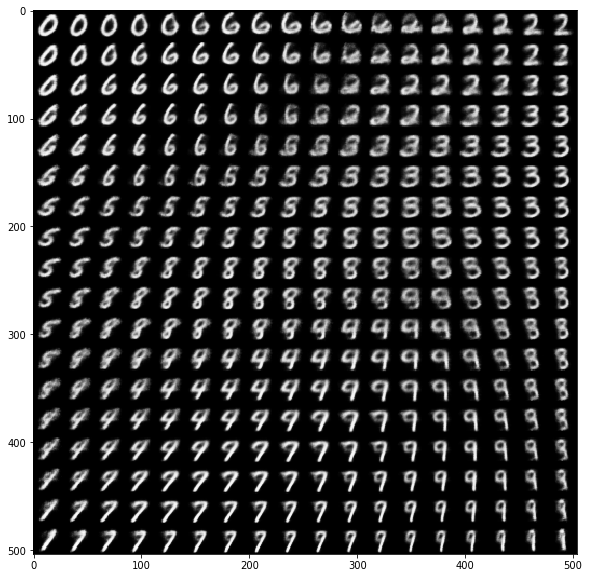

In [96]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [0]:
def custom_image(x_axis=True, reverse=False, index=0):
  custom_fig = np.zeros((digit_size, digit_size * n))
  for i, xi in enumerate(grid_x):
      if x_axis is True:
          z_sample = np.array([[xi, grid_y[index]]])
      else:
          z_sample = np.array([[grid_y[index], xi]])
      z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
      x_decoded = decoder.predict(z_sample, batch_size=batch_size)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      if reverse is False:
          custom_fig[0:digit_size, i*digit_size:(i+1)*digit_size] = digit
      else:
          custom_fig[0:digit_size, (len(grid_x)-1-i)*digit_size:((len(grid_x)-1-i)+1)*digit_size] = digit
  return custom_fig

In [0]:
imgs1 = custom_image(True, False, 0)
imgs2 = custom_image(False, False, n-1)
imgs3 = custom_image(True, True, n-1)
imgs4 = custom_image(False, True, 0)

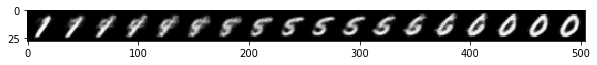

In [192]:
plt.figure(figsize=(10, 10))
plt.imshow(imgs4, cmap='Greys_r')
plt.show()

In [0]:
img_arrays = []
imgs = []
_ = np.concatenate([imgs1, imgs2, imgs3, imgs4], axis=1)
_ = np.split(_, len(grid_x)*4, axis=1)
for img in _:
    img = img.reshape(28, 28, 1)
    img_arrays.append(img)
    imgs.append(array_to_img(img))

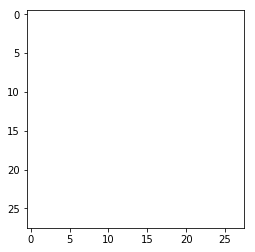

In [350]:
fig = plt.figure()
ims = []
for img in imgs:
    ims.append([plt.imshow(img, cmap='Greys_r')])     
anim = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
anim